Выполнил Самойлов Александр

In [ ]:
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 897.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency r

In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
# Импортируем необходимые библиотеки
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, BatchNormalization
# from tensorflow.keras.models import Model
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

Датасет

In [ ]:
# Загружаем датасет
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Изменяем тип на float32 и нормализуем
x_train_val = x_train_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Изменение размера изображений до 32x32
x_train_val_resized = tf.image.resize(x_train_val[..., tf.newaxis], [32, 32]).numpy()
x_test_resized = tf.image.resize(x_test[..., tf.newaxis], [32, 32]).numpy()

# Преобразование одноканальных изображений в трехканальные (RGB)
x_train_val_rgb = np.repeat(x_train_val_resized, 3, axis=-1)
x_test_rgb = np.repeat(x_test_resized, 3, axis=-1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Половину отдаем на валидационный сет, чтобы скорректировать работу сети
x_train, x_val = x_train_val_rgb[:30000], x_train_val_rgb[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val, x_train_val_rgb, x_test # Очищаем память, чтобы колаб из-за нехватки ОЗУ не прекратил работу

In [ ]:
def my_make_pairs(x, y):
    """
    Создает tuple, содержащий пары изображений с соответствующей меткой.

    x: List, содержащий изображения, каждому индексу изображения соответствует один индекс в y.
    y: List, содержащий метки, каждая метка - это int.
    Возвращает tuple из 2-х numpy arrays как (pairs_of_samples, labels).
    """

    # Находим максимальное значение в y (метках) и добавляем 1, чтобы получить общее количество классов.
    num_classes = max(y) + 1

    # Создаем список индексов для каждого класса. np.where(y == i)[0] возвращает индексы, где метка равна i.
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    # Инициализируем пустые списки для пар изображений и меток.
    pairs = []
    labels = []

    # Проходим по всем индексам в x.
    for idx1 in range(len(x)):
        # Выбираем первое изображение и его метку.
        x1 = x[idx1]
        label1 = y[idx1]

        # Случайным образом выбираем второй индекс из тех же меток, что и у x1.
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        # Добавляем пару похожих изображений и метку 0 (похожие).
        pairs += [[x1, x2]]
        labels += [0]

        # Выбираем случайную метку для создания пары непохожих изображений.
        label2 = random.randint(0, num_classes - 1)
        # Повторяем выбор метки, пока она не будет отличаться от label1.
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        # Выбираем индекс изображения с меткой label2.
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        # Добавляем пару непохожих изображений и метку 1 (непохожие).
        pairs += [[x1, x2]]
        labels += [1]

    # Преобразуем списки в numpy массивы и возвращаем их.
    # np.array(pairs) создает массив пар изображений, np.array(labels).astype("float32") преобразует метки в float32.
    return np.array(pairs), np.array(labels).astype("float32")

#  Создаем тренировочный сет
pairs_train, labels_train = my_make_pairs(x_train, y_train)

# Создаем валидационный сет
pairs_val, labels_val = my_make_pairs(x_val, y_val)

# Создаем тестовый сет
pairs_test, labels_test = my_make_pairs(x_test_rgb, y_test) # pairs_test.shape = (20000, 32, 32, 3)

# Cразу ограничим тестовый сет до 1000 пар, где 500 пар будет с меткой похожий, 500 пар с меткой непохожие
# Определяем индексы для похожих и непохожих пар
similar_indices = np.where(labels_test == 0)[0]
dissimilar_indices = np.where(labels_test == 1)[0]

# Выбираем случайных 500 индексов из каждой категории
np.random.seed(42)
selected_similar = np.random.choice(similar_indices, 500, replace=False) # Выбираем пары с меткой 0(похоже)
selected_dissimilar = np.random.choice(dissimilar_indices, 500, replace=False) # Выбираем пары с меткой 1(не похожи)

# Объединеняем индексы
selected_indices = np.concatenate([selected_similar, selected_dissimilar])

# Формируем новые массивы изображений и меток. Он будет упорядоченный сначала будут похожие, потом непохожие
selected_pairs = pairs_test[selected_indices] # selected_pairs.shape = (1000, 32, 32, 3)
selected_labels = labels_test[selected_indices]

# Перемешиваем выбранных данных
shuffle_order = np.random.permutation(np.arange(len(selected_indices)))
pairs_test = selected_pairs[shuffle_order] # selected_pairs.shape = (20000, 32, 32, 3)
labels_test = selected_labels[shuffle_order]


In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 32, 32, 3)
x_train_2 = pairs_train[:, 1]  # x_train_2.shape is (60000, 32, 32, 3)
x_train_1.shape

(60000, 32, 32, 3)

In [ ]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 32, 32, 3)
x_val_2 = pairs_val[:, 1]  # x_val_2.shape = (60000, 32, 32, 3)
x_val_1.shape

(60000, 32, 32, 3)

In [ ]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (1000, 32, 32, 3)
x_test_2 = pairs_test[:, 1]  # x_test_2.shape = (1000, 32, 32, 3)
x_test_1.shape

(1000, 32, 32, 3)

In [ ]:
def show_pairs(pairs , labels , to_show=6 , num_col=3 , predictions=None , test=False ):
    """Создаем изображение пар и их меток, и предсказания, если это тестовый сет

        pairs: np array пар изображений, чтобы отобразить , (Количество пар, 2, 32, 32, 3).

        to_show: Int, количество примеров для визуализации (по умолчанию 6)
                 to_show должно быть целым кратным num_col.
                 В противном случае оно будет обрезано, если оно больше num_col,
                 и увеличено, если оно меньше num_col.
        num_col: Int, количество изображений в одной строке - (по умолчанию 3)
                 Для test и train соответственно оно не должно превышать 3 и 7.
        predictions: Np array предсказаний с формой (to_show, 1) - (по умолчанию нет)
                 Должен быть передан, когда test=True.
        test: Логическое значение, указывающее, является ли визуализируемый набор
              данных обучающим набором данных или тестовым набором данных - (по умолчанию False).
    """

    # Рассчитываем количество строк на основе to_show и num_col. Если результат деления равен 0, используем 1 строку
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # Корректируем to_show на основе рассчитанного num_row и num_col, чтобы убедиться, что оно кратно num_col
    to_show = num_row * num_col

    # Создаем фигуру и оси для подграфиков с заданным количеством строк и столбцов. figsizе устанавливает размер фигуры
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))

    # Проходим по каждому элементу, который нужно отобразить
    for i in range(to_show):
        # Если только одна строка, выбираем ось по модулю количества столбцов
        if num_row == 1:
            ax = axes[i % num_col]
        # В противном случае определяем ось по индексу строки и столбцу
        else:
            ax = axes[i // num_col, i % num_col]

        # Визуализируем пару изображений, объединенных по горизонтали. Используем 'concatenate' для объединения и 'imshow' для отображения
        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        # Убираем оси для чистоты визуализации
        ax.set_axis_off()

        # Если это тестовый набор, отображаем метку и предсказание; иначе только метку
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))

    # Адаптируем расположение подграфиков в зависимости от того, тестовый набор или нет, для лучшего отображения
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))

    # Отображаем созданные подграфики.
    plt.show()


Класс SiameseNetwork

In [ ]:
class SiameseNetwork:
    def __init__(self, input_shape=(32, 32, 3)):
        # Инициализируем сиамскую сеть с заданной формой входных данных
        self.input_shape = input_shape  # Сохраняем формы входных данных
        self.base_model = self.load_base_model()  # Загружаем базововую модель VGG16
        # Строим сети для создания эмбеддингов (векторов признаков) из выхода базовой модели
        self.embedding_network = self.build_embedding_network(self.base_model.output_shape[1:])
        self.model = self.build_siamese_model()  # Собираем сеть

    def load_base_model(self):
        # Загружаем предварительно обученную модель VGG16 без верхних слоев.
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=self.input_shape))
        for layer in base_model.layers:
            layer.trainable = False  # Замораживаем слои для предотвращения их обучения
        return base_model

    def build_embedding_network(self, base_model_output_shape):
        # Создаем сеть для преобразования выхода базовой модели в вектор признаков
        input_layer = Input(shape=base_model_output_shape)  # Входной слой с формой, соответствующей выходу базовой модели
        x = Flatten()(input_layer)  # Выравниваем вектор для полносвязных слоев
        x = Dense(512, activation='relu')(x)  # Полносвязный слой с ReLU активацией
        x = BatchNormalization()(x)  # Нормализация для улучшения сходимости, чтобы исправить распределение
        x = Dense(100, activation='relu')(x)  # Выходной слой строки признаков с размерностью 100
        model = Model(inputs=input_layer, outputs=x)
        return model

    def build_siamese_model(self):
        # Сборираем сиамскую модель с двумя входами и одним выходом
        input_1 = Input(shape=self.input_shape)
        input_2 = Input(shape=self.input_shape)

        # Применяем базовую модель и эмбеддинг-модель к обоим входам
        processed_1 = self.base_model(input_1)
        processed_2 = self.base_model(input_2)
        tower_1 = self.embedding_network(processed_1)
        tower_2 = self.embedding_network(processed_2)

        # Расчитываем евклидово расстояние между эмбеддингами двух входов
        euclid_layer = Lambda(lambda tensors: K.sqrt(K.sum(K.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))([tower_1, tower_2])
        normal_layer = BatchNormalization()(euclid_layer)  # Нормализация для улучшения сходимости, чтобы исправить распределение
        output_layer = Dense(1, activation="sigmoid")(normal_layer)  # Выходной слой с сигмоидной активацией для классификации

        # Определяем модель с двумя входами и одним выходом.
        model = Model(inputs=[input_1, input_2], outputs=output_layer)
        return model


In [ ]:
siamese = SiameseNetwork() # Инициализируем сеть


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'Model' is not defined

Контрастивная ошибка

In [ ]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Рассчитывает контрастивную ошибку.

    y_true: Тензор меток, каждая метка имеет тип float32.
    y_pred: Тензор предсказаний той же длины, что и у y_true, каждое предсказание имеет тип float32.
    margin: Плавающее значение, указывающее пороговое значение для различия между классами.

    Возвращает значение контрастивной ошибки как тензор типа float32.
    """
    # Квадрат предсказанного расстояния. Наказывает за близкие расстояния между не похожими парами
    square_pred = tf.square(y_pred)

    # Вычисляем квадрат маржи минус предсказанное расстояние, ограниченное снизу нулём
    margin_square = tf.square(tf.maximum(margin - y_pred, 0.0))

    # Вычисляем итоговую потерю как среднее значение суммы потерь для похожих и не похожих пар
    loss = tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

Обучение

In [ ]:
epochs = 10 # Количество эпох обучения
batch_size = 16 # Размеры батча

In [ ]:
siamese.model.compile(
    loss=contrastive_loss,  # Установка функции потерь
    optimizer="RMSprop",  # RMSprop адаптирует скорость обучения для каждого параметра, чтобы полвека не ждать чуда
    metrics=["accuracy"]  # Указываем, что нужно выводить метрику accurancy
)

In [ ]:
siamese.model.fit(
    [x_train_1, x_train_2],  # Входные данные для обучения, состоящие из пар изображений
    labels_train,  # Метки обучающего набора, где каждая метка указывает, являются ли пары изображений похожими
    validation_data=([x_val_1, x_val_2], labels_val),  # Данные для валидации, все аналогично тренировочным
    batch_size=batch_size,  # Размер батча, чтобы определить сколько обрабатывать за один шаг обучения.
    epochs=epochs,  # Количество эпох обучения
)

Расчитываем метрики

In [ ]:
# Получаем предсказания модели на тестовом наборе
predictions = siamese.model.predict([x_test_1, x_test_2])

# Преобразовываем предсказания к бинарным значениям, чтобы избежать ValueError: Classification metrics can't handle a mix of binary and continuous targets
predictions_binary = (predictions > 0.5).astype(np.int64)

# Расчёт метрик
accuracy = accuracy_score(labels_test, predictions_binary)
precision = precision_score(labels_test, predictions_binary)
recall = recall_score(labels_test, predictions_binary)

# Вывод метрик
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Получаем предсказания модели на тестовом наборе, но упорядоченном сначала идут 0,...,0,1,....1
# Нужно поскольку тестовый набор перемешан, а нам нужно по 4 пары на каждую метку
demo_predictions = siamese.model.predict([selected_pairs[:,0],selected_pairs[:,1]])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.9640
Precision: 0.9531
Recall: 0.9760
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Визуализация

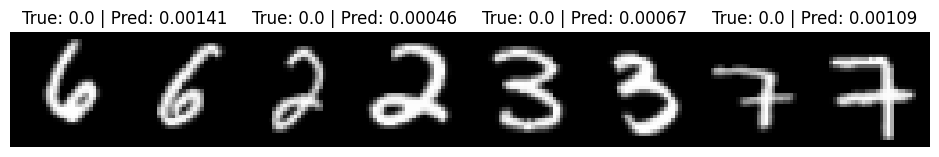

In [ ]:
show_pairs(selected_pairs, selected_labels, to_show=4, num_col=4, predictions=demo_predictions, test=True) # 4 пары для похожих

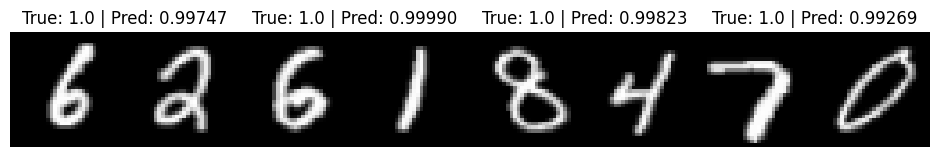

In [ ]:
show_pairs(selected_pairs[::-1], selected_labels[::-1], to_show=4, num_col=4, predictions=demo_predictions[::-1], test=True) # 4 пары для непохожих

In [ ]:
siamese.model.summary() # Структура сети

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 1, 1, 512)      │     14,714,688 │ input_layer_6[0][0],   │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ (None, 100)            │        316,004 │ vgg16[0][0],           │
│                           │                        │                │ vgg16[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_5[0][0],    │
│                           │                        │                │ functional_5[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 1)              │              4 │ lambda_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │              2 │ batch_normalization_3… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,030,698 (57.34 MB)

 Trainable params: 314,984 (1.20 MB)

 Non-trainable params: 14,715,714 (56.14 MB)

У нас около 300к обучаемых параметров, ма дополнили сеть полносвязанными слоями, нормализовали, последний слой имеет размерность ровно 100.
Затем мы получаем вектора изображений из пары, считаем их евклидово расстояние и выводим.

Заимствовал контрастивную ошибку, функцию визуализации, функцию создания пар (модернизировал) отсюда https://keras.io/examples/vision/siamese_contrastive/